# Применение оптимального транспорта для решения задачи сравнения распределений в $А/В$ тестировании на синтетических данных. Данный код относится к разделу 2.2 отчета о НИР.

In [23]:
#pip install POT==0.4.0

In [24]:
import pandas as pd
import numpy as np
import scipy
from numpy.linalg import norm
from numpy.random import default_rng
from random import choice
import cvxpy as cvx

import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import pickle
import importlib
import os, sys
import ot

from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
from matplotlib.patches import Ellipse
from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.ticker import StrMethodFormatter


from scipy.optimize import linear_sum_assignment
import re

In [25]:
def cost_matrix(X, Y):
    """
    Функция для построения ценовой матрицы C, где c_ij = ||X_i - Y_j||_2^2

    Параметры:
        X - array - выборка
        Y - array - выборка 
    Выход:
        cost - list[list] - ценовая матрица
    """
    x = np.shape(X)[0]
    y = np.shape(Y)[0]
    cost  = [[norm(X[i] - Y[j])**2 for i in range(x)] for j in range(y)]
    return(cost)

def gen_random_ball(dimension, num_points, rs = None, radius = 1):
    """
    Функция для генерации точек из равномерного распределения на шаре

    Параметры:
        dimension - int - размерность
        num_points - int - число объектов
        rs - int - для фиксации случайности
        radius - int - радиус шара
    Выход:
        ball - array - матрица размером num_points x dimension
    """

    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball)
    rng = default_rng(rs)
    random_directions = rng.standard_normal(size=(dimension, num_points))
    random_directions /= norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = rng.random(num_points) ** (1/dimension)
    # Return the list of random (direction & length) points.
    ball = radius * (random_directions * random_radii).T
    return ball

def split_data_randomly(d):
    """
    Функция случайно делит выборку из 2n точек на 2 группы по n точек

    Параметры:
        d - array -  матрица с данными
    Выход:
        s1 - array - объекты, попавшие в первую выборку
        s2 - array - объекты, попавшие во вторую выборку
    """
    ind = np.arange(d.shape[0])
    np.random.shuffle(ind)
    n = int(len(d)/2)
    ind1 = ind[:n]
    ind2 = ind[n:]

    s1 = d[ind1]
    s2 = d[ind2]
    return s1, s2

def compute_critical_level_pot(ball, N, alpha):
    """
    Функция калибровки критического значения (алгоритм 3 из раздела 2.2.1 отчета)

    Параметры:
        ball - array - матрица с точками равномерного распределения на шаре
        N - int - число итераций
        alpha - float - уровень значимости
    Выход:
        cr_level - float - критическое значение
    """
    n = int(len(ball)/2)
    stat = []
    m0     = [1/n] * n
    m1     = [1/n] * n
    
    for i in range(0, N):
        s1, s2 = split_data_randomly(d = ball)
        plan = computeOT(s1, s2, 'distance') #ot distance
        stat.append(plan)

    q = (1 - alpha)*100
    cr_level = np.percentile(stat, q)
    return cr_level

def compute_critical_level(ball, N, alpha):
    """
    Функция калибровки критического значения (алгоритм 3 из раздела 2.2.1 отчета)

    Параметры:
        ball - array - матрица с точками равномерного распределения на шаре
        N - int - число итераций
        alpha - float - уровень значимости
    Выход:
        cr_level - float - критическое значение
    """
    n = int(len(ball)/2)
    stat = []
    m0     = [1/n] * n
    m1     = [1/n] * n
    
    for i in range(0, N):
        s1, s2 = split_data_randomly(d = ball)
        M = cost_matrix(s1, s2)
        M = np.array(M)
        plan = ot.emd2(m0, m1, M) #ot distance
        stat.append(plan)

    q = (1 - alpha)*100
    cr_level = np.percentile(stat, q)
    return cr_level

def computeOT(s, t, mode):
    """
    Функция для подсчета оптимального транспортного плана 

    Параметры:
        s - array - выборка
        t - array - выборка
        mode - str - если равен "plan", то в функции находится оптимальный транспортный план, если значение равно "distance", то возвращается расстояние
    Выход:
        Если mode = "plan", то plan - array - искомый оптимальный план 
        Если mode = "distance", то plan - float - найденное расстояние
    """
    n = len(s)
    k = len(t)
    m0     = [1/n] * n
    m1     = [1/k] * k
    M = cost_matrix(s, t)
    M = np.array(M)
    if mode == 'plan':
        plan = ot.emd(m0, m1, M) #transport plan
    elif mode == 'distance':
        plan = ot.emd2(m0, m1, M)
    return plan

def computeOT_cvx(s, t, mode):
    """
    Функция для подсчета оптимального транспортного плана 

    Параметры:
        s - array - выборка
        t - array - выборка
        mode - str - если равен "plan", то в функции находится оптимальный транспортный план, если значение равно "distance", то возвращается расстояние
    Выход:
        Если mode = "plan", то plan - array - искомый оптимальный план 
        Если mode = "distance", то plan - float - найденное расстояние
    """
    n = len(s)
    k = len(t)
    m0 = np.array([1/n] * n)
    m1 = np.array([1/k] * k)
    M = cost_matrix(s, t)
    M = np.array(M)
    
    P = cvx.Variable((n, k))
    obj = cvx.Minimize(cvx.trace(M.T @ P))
    constraints = [P @ np.ones(k) == m0, P.T @ np.ones(n) == m1, P >= 0]
    
    prob = cvx.Problem(obj, constraints)
    prob.solve()
    
    if mode == 'plan':
        plan = P.value #transport plan
    elif mode == 'distance':
        plan = obj.value
    return plan


# #returns OT distance
# def computeOT2(s, t):
#     n = len(s)
#     k = len(t)
#     m0     = [1/n] * n
#     m1     = [1/k] * k
#     M = cost_matrix(s, t)
#     M = np.array(M)
#     plan = ot.emd2(m0, m1, M) #transport plan
#     return plan

#OT Map


def compute_distance(s1, s2, t):
    """
    Функция для подсчета расстояние 2-Вассерштейна между эмпирическими распределениями (шаг 2 из алгоритма 3)

    Параметры:
        s1 - array - выборка
        s2 - array - выборка
        t - array - целевое распределение
    Выход:
        dst_fin - float - расстояние
    """  
    ##Step 2 in Algorithm 3: OT distance between ball partitions 
    ## induced by the transport of two data distributions
    L = len(s1)
    s = np.concatenate((s1, s2), axis = 0)
    plan = computeOT(s = t, t = s, mode = 'plan')
    # Матрица оптимального плана содержит только 2L ненулевых элементов,
    # однако из-за вычислительных погрешностей у найденного решения
    # будет много элементов, близких к нулю.
    # Отсекаем их вручную на уровне 10^{-6}
    plan = plan * np.abs(plan > 1e-6)
    ind = [np.nonzero(plan[i])[0][0] for i in range(2*L)] #indices of assigned distributions
    
    #split target t
    ind_t1 = []
    ind_t2 = []
    for i in range(0, len(s)):
        if i < L:
            ind_t1.append(ind[i])
        else:
            ind_t2.append(ind[i])
   
    t1 = t[ind_t1]
    t2 = t[ind_t2]
    dst_fin = computeOT(s = t1, t = t2, mode = 'distance')
    
    return dst_fin

# Вспомогательные функции для отрисовки графиков

def decompose(X, method = 'numpy.eigh'):
    """Собственное разложение матрицы X"""
    if method == "tf.eig":
        import tensorflow as tf
        A_tf = tf.convert_to_tensor(X)
        eigvals, eigvects = tf.linalg.eig(A_tf)
        eigvals, eigvects = eigvals.numpy(), eigvects.numpy()
    elif method == "tf.eigh":
        import tensorflow as tf
        A_tf = tf.convert_to_tensor(X)
        eigvals, eigvects = tf.linalg.eigh(A_tf)
        eigvals, eigvects = eigvals.numpy(), eigvects.numpy()
    elif method == "numpy.eig":
        eigvals, eigvects = np.linalg.eig(X)
    elif method == "numpy.eigh":
        eigvals, eigvects = np.linalg.eigh(X)
    else:
        raise NotImplementedError('Unknown method: ' + method)
    return eigvals, eigvects

def sqrtmInv(X, method='numpy.eigh'):
    """Вычисление обратной матрицы к корню матрицы X"""
    eigval, eigvects = decompose(X, method)
    Y = (eigvects / np.sqrt(np.maximum(eigval, 0))[np.newaxis,:]).dot(eigvects.T)
    return(Y)

def sqrtm(X, method='numpy.eigh'):
    """Вычисление корня симметричной матрицы"""
    eigval, eigvects = decompose(X, method)
    Y = (eigvects * np.sqrt(np.maximum(eigval, 0))[np.newaxis,:]).dot(eigvects.T)
    return(Y)


def BW(K1, K2, method='numpy.eigh'):
    """Вычисление 2-Вассерштейн расстояния между матрицами ковариаций нормального распределения"""
    Q = sqrtm(K1, method)
    d = np.sqrt(np.maximum(0, K1.trace() + K2.trace() - 2 * sqrtm(Q.dot(K2).dot(Q), method).trace()))
    return d

def OT_map(V, U):
    #map from V to U
    sqU = sqrtm(U,method='numpy.eigh')
    Cn  =  (sqU @ V) @ sqU
    Z = sqrtmInv(Cn, method='numpy.eigh')
#     pinvCn = pinvsq(Cn)
    T = (sqU @ Z) @ sqU
    return T

def OT_geod(V, T, t):
    E = np.array([[1,0],[0, 1]])
    Z = E * (1-t) + t*T
    V = Z @ V 
    W = V @ Z
    return W

# Эксперименты на синтетических данных из раздела 2.2.2 отчета

В данных экспериментах рассматриваются две выборки одинакового размера, пришедшие из центрированных двумерных Гауссовских распределений с матрицами ковариаций
$$
C_1 = \begin{pmatrix}
5 & 2 \\
2 & 2 
\end{pmatrix},
\quad
C_2 = \begin{pmatrix}
12 & 4 \\
4 & 15 
\end{pmatrix}.
$$

In [26]:
m = [0, 0]

# Выборка X
C1=np.array([[5, 2], [2, 2]])

# Выборка Y
C2=np.array([[12.0, 4], [4, 15.0]])
m = [0, 0]
 

## Исследование поведения метода на выборках разного размера

В данном эксперименте рассматривались размеры выборок равные 10, 20, 30, 50, 70

In [30]:
# Значения параметров размера выборки
import time 

grd = [10,20]

test_values  = []

# Число итераций алгоритма
Z = 10

critical_levels = []
for g in tqdm(grd):

    # Алгоритм 2, шаг 2
    start_time = time.time()
    b = gen_random_ball(dimension=2, num_points=2*g, rs=None, radius = 1)
    print("gen random ball time: ",time.time() - start_time)
    # Алгоритм 3
    start_time = time.time()
    cr_l = compute_critical_level(ball = b, N=1500, alpha=.05)
    print("gen critical level time: ",time.time() - start_time)
    critical_levels.append(cr_l)
    
    #resampling for a given sample size: store test values 
    dummy = []
    print("in loop")
    for j in range(0, Z):
        # Генерация синтетических выборок
        start_time = time.time()
        s1 = np.random.multivariate_normal(m, C1, g)
        s2 = np.random.multivariate_normal(m, C2, g)
        print("data synt time: ",time.time() - start_time)
        
        # Подсчет тестовой статистики (Алгоритм 2, шаги 1, 3, 4, 5)
        start_time = time.time()
        plan = computeOT(s1, s2, 'plan')
        print("computeOT time:",time.time() - start_time)
        start_time = time.time()
        dst = compute_distance(s1 = s1, s2 =s2, t=b)
        print("compute_distance time:",time.time() - start_time)
        dummy.append(dst)
    test_values.append(dummy)  

  0%|                                                     | 0/2 [00:00<?, ?it/s]

gen random ball time:  0.0045278072357177734


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.33it/s]

gen critical level time:  0.40848684310913086
in loop
data synt time:  0.00037288665771484375
computeOT time: 0.0002779960632324219
compute_distance time: 0.001207113265991211
data synt time:  7.390975952148438e-05
computeOT time: 0.00023508071899414062
compute_distance time: 0.0011599063873291016
data synt time:  6.198883056640625e-05
computeOT time: 0.00023794174194335938
compute_distance time: 0.0011560916900634766
data synt time:  5.91278076171875e-05
computeOT time: 0.00023293495178222656
compute_distance time: 0.0011599063873291016
data synt time:  5.888938903808594e-05
computeOT time: 0.00024008750915527344
compute_distance time: 0.0011572837829589844
data synt time:  5.698204040527344e-05
computeOT time: 0.00023603439331054688
compute_distance time: 0.00115203857421875
data synt time:  5.7220458984375e-05
computeOT time: 0.00023508071899414062
compute_distance time: 0.0011589527130126953
data synt time:  5.602836608886719e-05
computeOT time: 0.0002357959747314453
compute_distan

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

gen critical level time:  1.410937786102295
in loop
data synt time:  0.00015163421630859375
computeOT time: 0.0012769699096679688
compute_distance time: 0.0062351226806640625
data synt time:  7.605552673339844e-05
computeOT time: 0.0013098716735839844
compute_distance time: 0.006111860275268555
data synt time:  0.0002181529998779297
computeOT time: 0.0009131431579589844
compute_distance time: 0.004513978958129883
data synt time:  8.106231689453125e-05
computeOT time: 0.0008928775787353516
compute_distance time: 0.004497051239013672
data synt time:  6.890296936035156e-05
computeOT time: 0.0009469985961914062
compute_distance time: 0.004439115524291992
data synt time:  6.4849853515625e-05
computeOT time: 0.0009100437164306641
compute_distance time: 0.004525661468505859
data synt time:  6.103515625e-05
computeOT time: 0.0008981227874755859
compute_distance time: 0.004499912261962891
data synt time:  6.008148193359375e-05
computeOT time: 0.0009090900421142578
compute_distance time: 0.00446

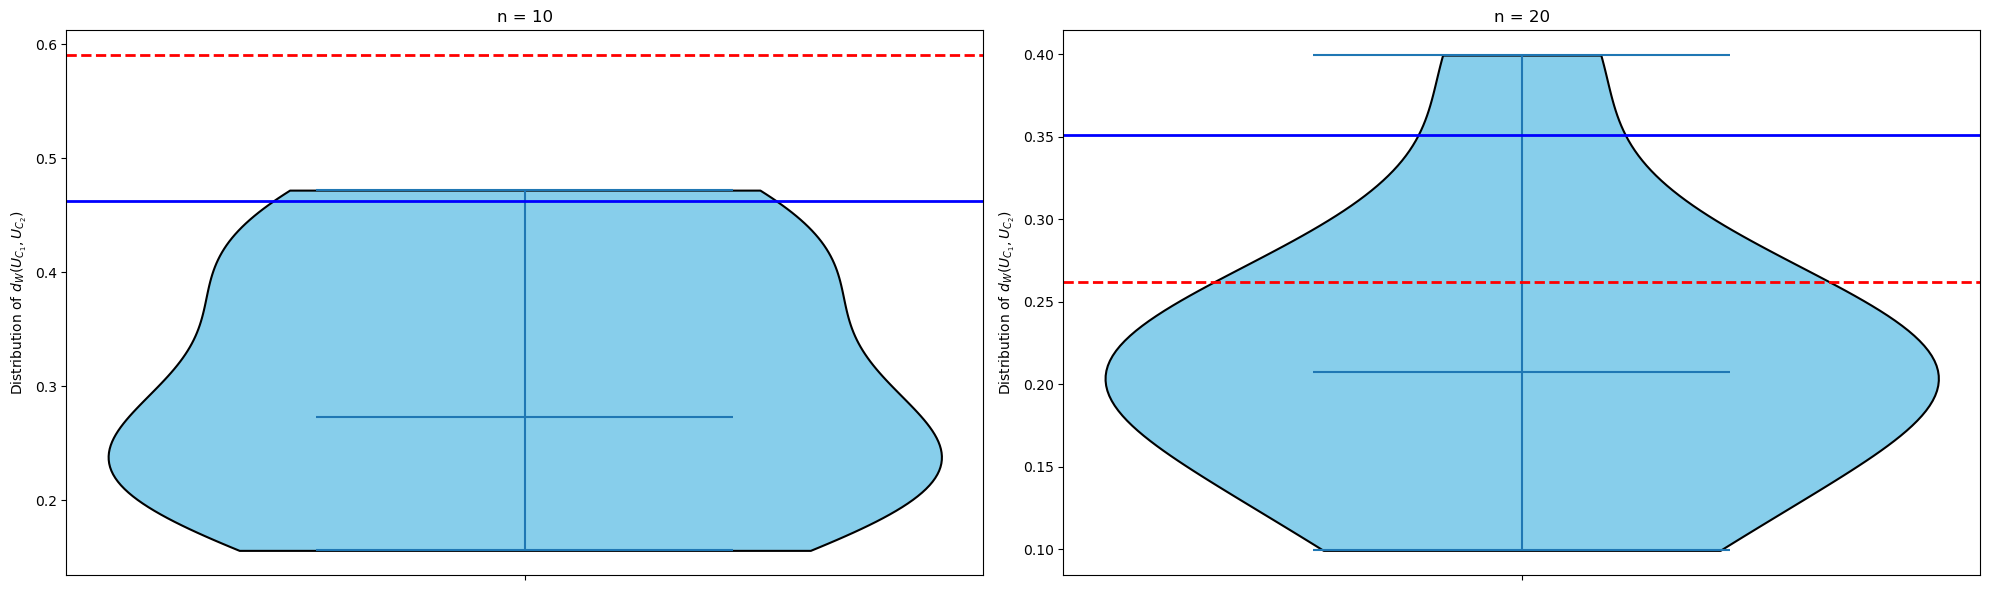

In [31]:
data = test_values

fig, axs = plt.subplots(1, len(grd), figsize=(20, 6))

for i, ax in enumerate(axs):
    parts = ax.violinplot(data[i], showmeans=False, showmedians=True)
    quantile_95 = np.percentile(data[i], 95)
    ax.axhline(y=quantile_95, color='blue', linestyle='-', linewidth=2)
    ax.axhline(y=critical_levels[i],  color='red', linestyle='--', linewidth=2)

    ax.set_title(f'n = {grd[i]}')
    ax.set_xticks([1])
    ax.set_xticklabels([''])
    ax.set_ylabel(r'Distribution of $d_{W}(U_{C_1}, U_{C_2})$')

    for pc in parts['bodies']:
        pc.set_facecolor('skyblue')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1.5)


plt.tight_layout()
plt.show()


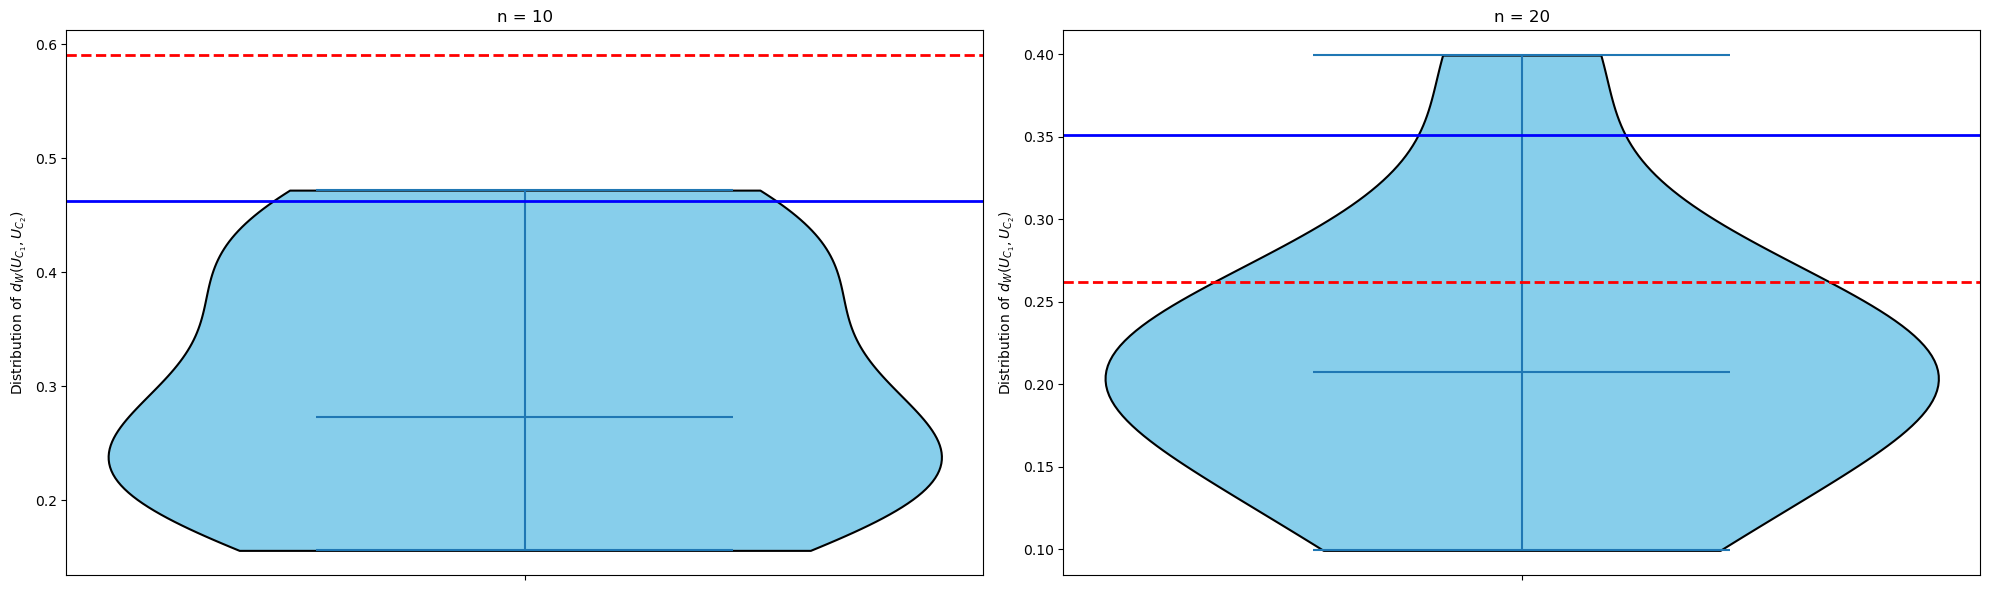

In [32]:
data = test_values

fig, axs = plt.subplots(1, len(grd), figsize=(20, 6))

for i, ax in enumerate(axs):
    parts = ax.violinplot(data[i], showmeans=False, showmedians=True)
    quantile_95 = np.percentile(data[i], 95)
    ax.axhline(y=quantile_95, color='blue', linestyle='-', linewidth=2)
    ax.axhline(y=critical_levels[i],  color='red', linestyle='--', linewidth=2)


    ax.set_title(f'n = {grd[i]}')
    ax.set_xticks([1])
    ax.set_xticklabels([''])
    ax.set_ylabel(r'Distribution of $d_{W}(U_{C_1}, U_{C_2})$')

    
    for pc in parts['bodies']:
        pc.set_facecolor('skyblue')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1.5)


plt.tight_layout()
plt.show()


## Анализ чувствительности метода к разладке

Для проведения данного эксперимента поведение метода было исследовано на различных ковариационных матрицах $C_t$, лежащих между $C_1$ и $C_2$ на геодезической в пространстве $2$-Вассерштейна,
$$
C_t = (E(1-t) + Tt)C_0(E(1-t) + Tt), 
\quad
t\in [0, 1],
$$
где 
$
E = \begin{pmatrix}
1 & 0 \\
0 & 1 
\end{pmatrix},
\quad
T = C^{1/2}_1\left(C^{1/2}_1 C_0 C^{1/2}_1 \right)^{-1/2}C^{1/2}_1.
$

In [33]:
#Changepoint is simulated as a movement over geodesic in 2-Wasserstein space 
#connecting the data generating distributions N(0, C1) and N(0, C2)


#step at geodesic
grd = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]

#find optimal map between C1 and C2
mapT = OT_map(C1, C2)

#store change point values
stat_BW = []

#store test statistic values
stat_U  = []

#num of iterations to estimate the distribution of the test
Z = 100

#num of points in each sample
num_points = 80

# #generate points from uniform distributopm on a ball
b = gen_random_ball(dimension=2, num_points=2*num_points, rs=None, radius = 1) #(see Algorithm 2, steps 2) 

#compute critical level
cr_l = compute_critical_level(ball = b, N=1500, alpha=.05) #(see Algorithm 3) 

#move along geodesic
for t in grd:
    if t == 0:
        gC = C1
    elif t == 1:
        gC = C2
    else: 
         gC = OT_geod(C1, mapT, t)
    
    stat_BW.append(BW(C1, gC))#distance between data generating distributions
    dummy = []
    for j in tqdm(range(0, Z)):
        s1 = np.random.multivariate_normal(m, C1, num_points)
        s2 = np.random.multivariate_normal(m, gC, num_points)
        dst = compute_distance(s1 = s1, s2 =s2, t=b)
        dummy.append(dst)
    stat_U.append(dummy)
    

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.79it/s]


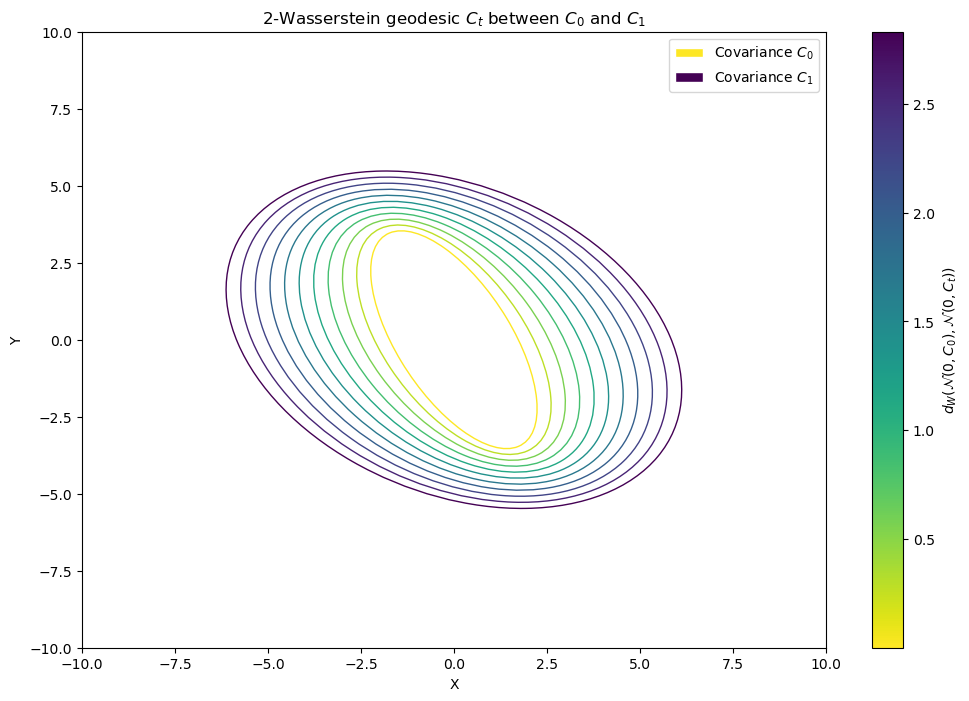

In [34]:
data_to_plot = np.array(stat_BW)


nrm = Normalize(vmin=data_to_plot.min(), vmax=data_to_plot.max())
colors = plt.cm.viridis_r(nrm(data_to_plot))


fig, ax = plt.subplots(figsize=(12, 8))

k = -1
for g in grd:
    k+=1
    gC = OT_geod(C1, mapT, g)
    eigenvalues, eigenvectors = np.linalg.eigh(gC)
    theta = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    ellipse = Ellipse((0, 0), 2 * np.sqrt(2.5 * eigenvalues[1]), 2 * np.sqrt(2.5 * eigenvalues[0]),
                      angle=theta, color=colors[k], fill = False)
    ax.add_patch(ellipse)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(r'2-Wasserstein geodesic $C_t$ between $C_0$ and $C_1$')


sm = ScalarMappable(norm=nrm, cmap=plt.cm.viridis_r)
sm.set_array([]) 
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$d_W(\mathcal{N}(0, C_0), \mathcal{N}(0, C_t))$')

legend_elements = [
    Patch(facecolor=colors[0], edgecolor='white', label=r'Covariance $C_0$'),
    Patch(facecolor=colors[-1], edgecolor='white', label=r'Covariance $C_1$')
]
ax.legend(handles=legend_elements)
plt.show()


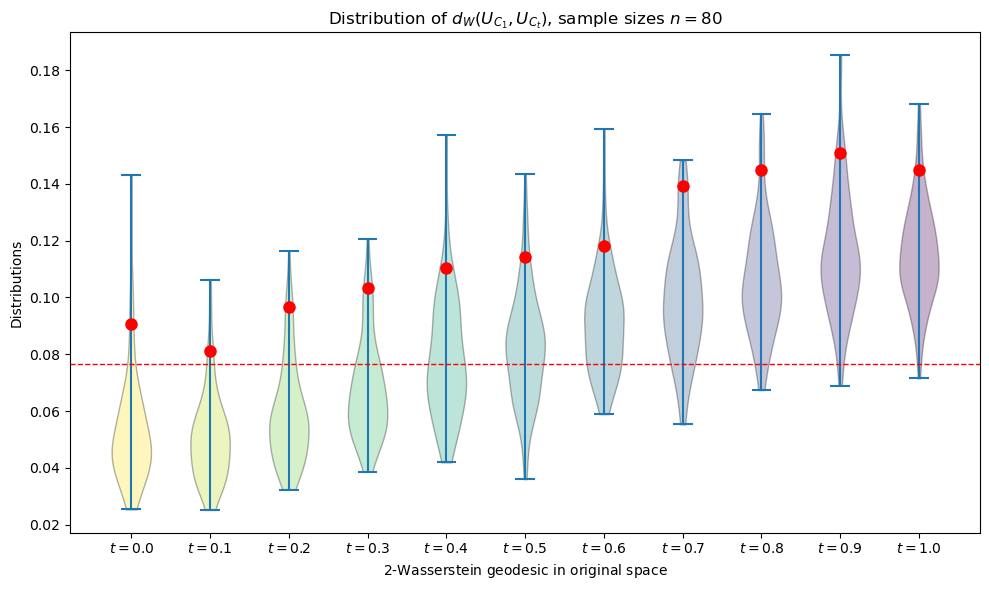

In [35]:

fig_violin, ax_violin = plt.subplots(figsize=(10, 6))

num_ticks = len(grd)

data_to_plot = stat_U
quantiles = [np.percentile(dataset, 95) for dataset in data_to_plot]

violin_parts = ax_violin.violinplot(data_to_plot, showmeans=False, showmedians=False)
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    ax_violin.plot([i + 1], [quantiles[i]], marker='o', markersize=8, color='red', zorder=3)



ax_violin.set_xticks(np.arange(1, num_ticks + 1))
ax_violin.set_xticklabels([fr'$t = {(i-1)/10}$' for i in range(1, num_ticks + 1)])
ax_violin.set_xlabel(r'$2$-Wasserstein geodesic in original space')
ax_violin.set_ylabel('Distributions')
ax_violin.set_title(r'Distribution of $d_{W}(U_{C_1}, U_{C_t})$, sample sizes $n=80$')

ax_violin.axhline(y=cr_l, color='red', linestyle='--', linewidth=1, label='Critical level')



plt.tight_layout()
plt.show()

